# Self-Driving Car Engineer Nanodegree

## Term 1 Project 5: Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
### Import necessary modules

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import glob

# import custom python script that stores the functions this project uses
import functions as fn

# show visualizetions in the notebook output cell
%matplotlib inline

### Load and Explore the Dataset

====== DATASET SUMMARY ======
Dataset has 500 positive samples, i.e. images of Cars.
Dataset has 500 negative samples, i.e. images without Cars.


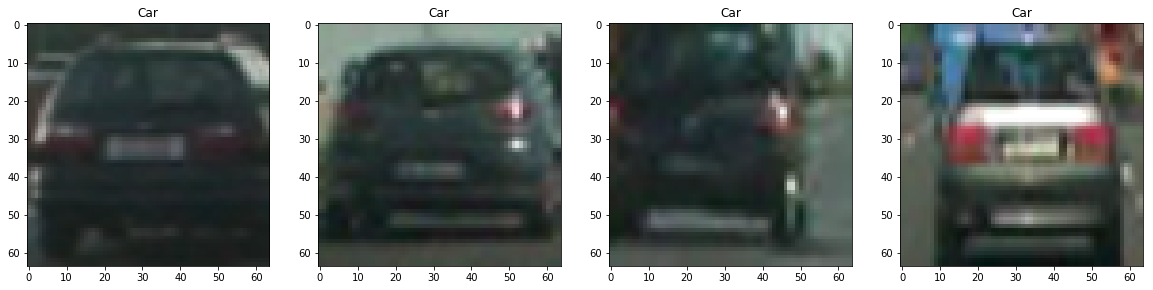

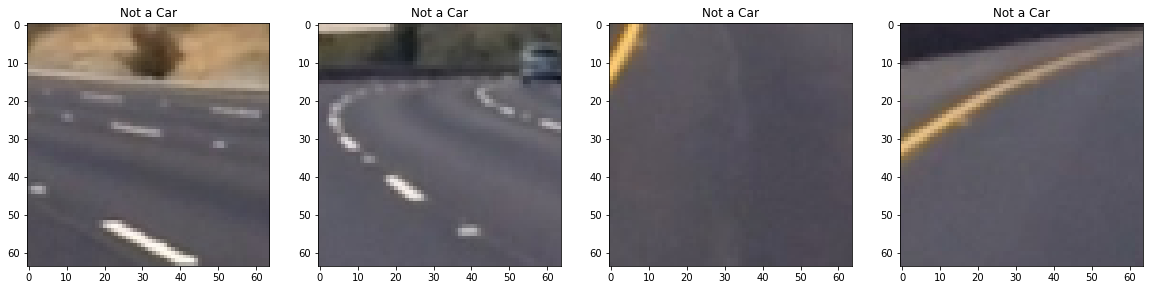

In [2]:
# load project dataset
car_paths = glob.glob('data/vehicles/**/*.png', recursive=True)
non_car_paths = glob.glob('data/non-vehicles/**/*.png', recursive=True)

# load car images into 
car_imgs = []
for path in car_paths[:500]:
    car_imgs.append(mpimg.imread(path))

# load non car images
non_car_imgs = []
for path in non_car_paths[:500]:
    non_car_imgs.append (mpimg.imread(path))

# print data set summary
print("====== DATASET SUMMARY ======")
print('Dataset has {} positive samples, i.e. images of Cars.'.format(len(car_imgs)))
print('Dataset has {} negative samples, i.e. images without Cars.'.format(len(non_car_imgs)))

# Plot randomly selected car samples
inds = np.random.choice(len(car_imgs), 4)

# initialize plot
plt.figure(figsize=(20, 12))

for i, ind in enumerate(inds):
    plt.subplot(1, 4, i+1)
    plt.imshow(car_imgs[ind])
    plt.title("Car")
    
# Plot randomly selected non-car samples
inds = np.random.choice(len(non_car_imgs), 4)

# initialize plot
plt.figure(figsize=(20, 12))

for i, ind in enumerate(inds):
    plt.subplot(1, 4, i+1)
    plt.imshow(non_car_imgs[ind])
    plt.title("Not a Car")

### HOG Features Extraction

In [3]:
### Set parameters of HOG feature extraction

# colorspace: Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'GRAY'

# HOG orientations
orientations = 16

# pixels per cell
pix_per_cell = 16

# cells per block
cell_per_block = 1

# number of channels to use for HOG features extraction. Can be 0, 1, 2, or "ALL"
hog_channels = 'ALL'

# extract hog features?
hog_features = True 

# extract histogram features?
histogram_features = False

# Number of histogram bins
histogram_bins = 16

# extract spatial features?
spatial_features = False

# spatial binning dimensions
spatial_size = (16, 16) 


/home/aqeel/anaconda3/envs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


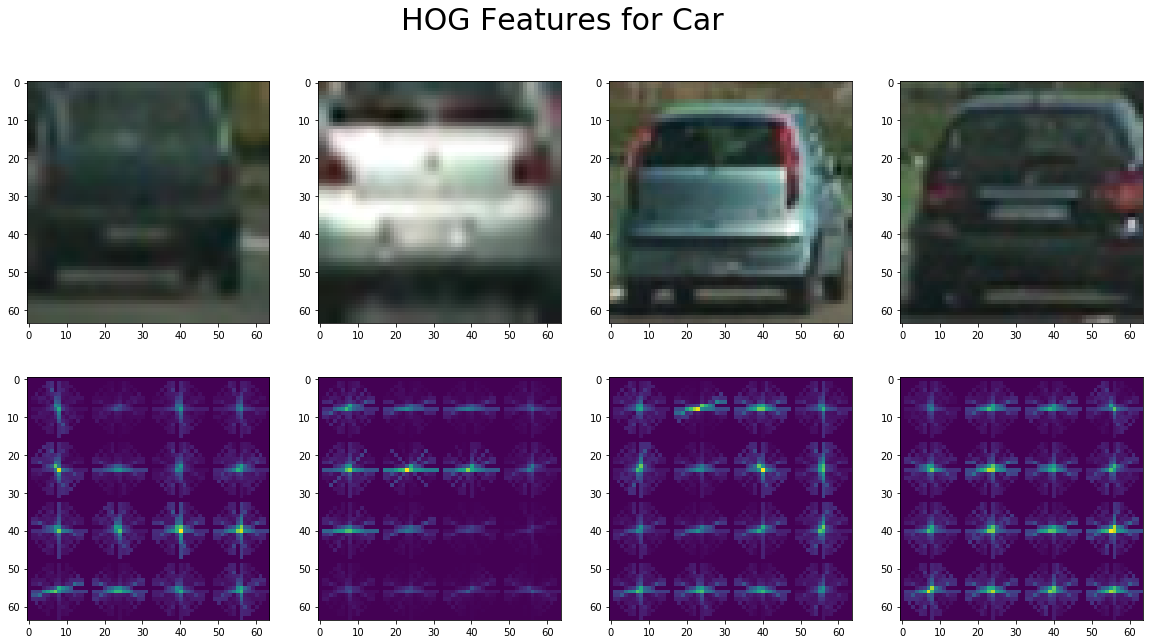

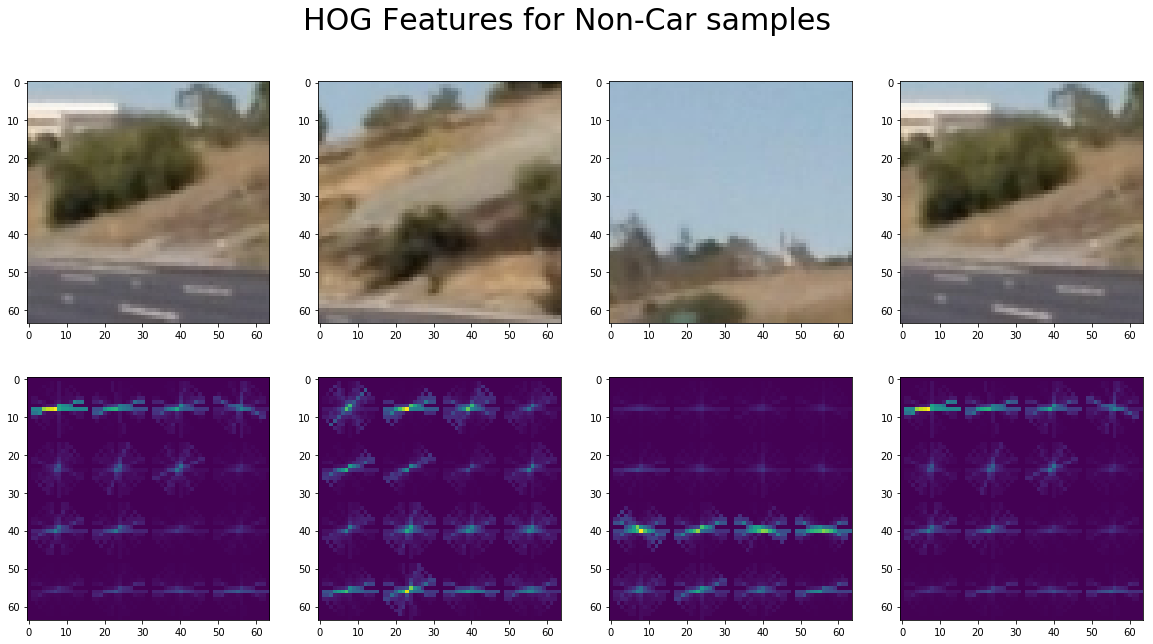

In [4]:
### Plot random samples their associated HOG Features 

from skimage.feature import hog
import math

# Plot randomly selected car samples
inds = np.random.choice(len(car_imgs), 4)

# initialize plot
plt.figure(figsize=(20, 10))

for i, ind in enumerate(inds):
    
    img = car_imgs[ind]
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    
    # convert to HLS and extract S channel
    hls_s = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[...,2]
    
    # get HOG feature image on the HLS S-channel converted car image 
    features, hog_img = hog(hls_s, orientations=orientations, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                              visualise=True, feature_vector=True)
    plt.subplot(2, 4, i+5)
    plt.imshow(hog_img)

plt.suptitle("HOG Features for Car ", size=30)


# Plot randomly selected non-car samples
inds = np.random.choice(len(non_car_imgs), 4)

# initialize plot
plt.figure(figsize=(20, 10))

for i, ind in enumerate(inds):
    
    img = non_car_imgs[ind]
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    
    hls_s = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[...,2]
    features, hog_img = hog(hls_s, orientations=orientations, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                              visualise=True, feature_vector=True)
    plt.subplot(2, 4, i+5)
    plt.imshow(hog_img)

plt.suptitle("HOG Features for Non-Car samples", size=30)

print()
    

In [5]:
### Extract features on which to train an SVM

import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

st = time.time()

# feature extraction arguments
args = (color_space, spatial_size, histogram_bins, orientations, pix_per_cell, cell_per_block, hog_channels, 
        spatial_features, histogram_features, hog_features)

car_features = fn.extract_features(car_imgs, *args)

non_car_features = fn.extract_features(non_car_imgs, *args)


print ('Total time for feature extraction: ', round(time.time() - st, 2), 'seconds')
print()

# create a feature set
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Length of Feature Vector:', len(X_train[0]))
print()
print('Length of Training Set:', len(X_train))
print('Length of Test Set:', len(X_test))


/home/aqeel/anaconda3/envs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Total time for feature extraction:  0.78 seconds

Length of Feature Vector: 256

Length of Training Set: 800
Length of Test Set: 200


### Train a Linear SVM

In [6]:
### Train and test the SVM

# initialize
svc = SVC()

# Check the training time for the SVC
st = time.time()

# Train
svc.fit(X_train, y_train)
print("Total training time: ", round(time.time() - st, 2), 'seconds')

# Test
st = time.time()
accuracy = svc.score(X_test, y_test)
print("Total testing time: ", round(time.time() - st, 2), 'seconds')
print('Test Accuracy of SVC = ', accuracy)



Total training time:  0.07 seconds
Total testing time:  0.01 seconds
Test Accuracy of SVC =  0.99


### Create Sliding Windows

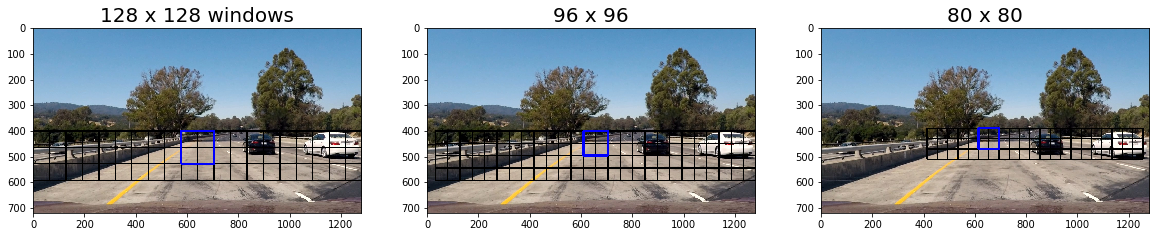

In [7]:
# defining parameters of sliding windows

image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

sw_x_limits = [[None, None], [32, None], [412, 1280]]

sw_y_limits = [[400, 640], [400, 600], [390, 540]]

sw_window_size = [(128, 128), (96, 96), (80, 80)]

sw_overlap = [(0.5, 0.5),(0.5, 0.5),(0.5, 0.5)]

# create sliding windows
windows = fn.slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = fn.slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = fn.slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# show sliding windows
sliding_windows = []
sliding_windows.append(fn.draw_boxes(np.copy(image), windows, color=(0, 0, 0), thick=4))
sliding_windows.append(fn.draw_boxes(np.copy(image), windows2, color=(0, 0, 0), thick=4))
sliding_windows.append(fn.draw_boxes(np.copy(image), windows3, color=(0, 0, 0), thick=4))

# drawing one of sliding windows in blue
sliding_windows [0] = fn.draw_boxes(sliding_windows [0], [windows[9]], color=(0, 0, 255), thick=8)
sliding_windows [1] = fn.draw_boxes(sliding_windows [1], [windows2[12]], color=(0, 0, 255), thick=8)
sliding_windows [2] = fn.draw_boxes(sliding_windows [2], [windows3[5]], color=(0, 0, 255), thick=8)

sw_titles = ['128 x 128 windows', '96 x 96', '80 x 80']

# show_images_in_table (sliding_windows, (3, 1), fig_size=(20, 14), titles=sw_titles)

# plot the windows
plt.figure(figsize=(20,10))

for i in range(len(sliding_windows)):
    plt.subplot(1,3,i+1)
    plt.imshow(sliding_windows[i])
    plt.title(sw_titles[i], size=20)

### Heat Maps based on Sliding Windows

In [ ]:
# algorithm demonstration on test images

# test_images = []
# test_images_titles = []

test_images = glob.glob('test_images/test*.jpg')

# initialize plot grid
plt.figure(figsize=(20,10))

# plot hot boxes, heatmaps and detection of all the test images
for i, path in enumerate(test_images):
    
    img = mpimg.imread(path)
    
    image = img.astype(np.float32)/255

    # hot boxes
    hot_boxes, hot_boxes_img = fn.hot_boxes(image, windows, svc, X_scaler)
    
    # plot hotboxes on the image
    plt.subplot(len(test_images), 3, 3*i + 1)
    plt.imshow(hot_boxes_img),
    if i == 0: plt.title("Hot Boxes", size=24)
    
    # heat map
    heat_map = fn.heat_map(image, hot_boxes)
    
    # plot heatmap of hotboxes
    plt.subplot(len(test_images), 3, 3*i + 2)
    plt.imshow(heat_map)
    if i == 0: plt.title("Heat Map", size=24)
    
    # average boxes
    avg_boxes = fn.average_boxes(hot_boxes, 2)
    detection_img = fn.draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    
    # plot detections based on average of hot boxes on the image
    plt.subplot(len(test_images), 3, 3*i + 3)
    plt.imshow(detection_img)
    if i == 0: plt.title("Detections", size=24)
    

    
#     test_images.append(image_with_hot_boxes)
#     test_images.append (heat_map)
#     test_images.append (image_with_boxes)
    
#     test_images_titles.extend (['', '', ''])
    
# test_images_titles [0] = 'hot boxes'
# test_images_titles [1] = 'heat map'
# test_images_titles [2] = 'average boxes'

# show_images_in_table (test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)

In [ ]:
# in video I use information from multiple frames to
# make average boxes more robust and filter false positives
# I accumulate all hot boxes from last several frames and use them
# for calculating average boxes

class LastHotBoxesQueue ():
    """Class for accumulation of hot boxes from last 10 frames
    """
    def __init__ (self):
        self.queue_max_len = 10 # number items to store
        self.last_boxes = []

    def put_hot_boxes (self, boxes):
        """Put frame hot boxes
        """
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop (0)
        
        self.last_boxes.append (boxes)
        
    def get_hot_boxes (self):
        """Get last 10 frames hot boxes
        """
        b = []
        for boxes in self.last_boxes:
            b.extend (boxes)
        return b

last_hot_boxes = LastHotBoxesQueue ()
    
def process_image (image_orig):
    
    image_orig = np.copy (image_orig)
    image = image_orig.astype(np.float32)/255
    
    # accumulating hot boxes over 10 last frames
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    last_hot_boxes.put_hot_boxes (hot_boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes ()
    
    # calculating average boxes and use strong ones
    # need to tune strength on particular classifer
    avg_boxes = calc_average_boxes (hot_boxes, 20)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)

    return image_with_boxes * 255

In [ ]:
from moviepy.editor import VideoFileClip
# import imageio
# imageio.plugins.ffmpeg.download()

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    
    # uncomment to operate on individual frames
#     image = clip.get_frame(8./30)
#     r = process_image(image)
#     plt_show (r/255)

    result = clip.fl_image (process_image)
    %time result.write_videofile (output_path)

# select video to operate on
# process_video ('test_video.mp4', 'test_video_result.mp4')
process_video ('project_video.mp4', 'project_video_result.mp4')
# process_video ('challenge_video.mp4', 'challenge_video_result.mp4')
# process_video ('harder_challenge_video.mp4', 'harder_challenge_video_result.mp4')
